# Development Notebook:

## SNR Region Extraction:

In [1]:
import Labber
import os
import sys
from fitTools.utilities import Watt2dBm, dBm2Watt, VNA2dBm

from twpa_tune_up_helper_functions import *


/Users/shanto/miniforge3/envs/lfl_qp/lib/python3.9/site-packages/qtpy/__init__.py:214: RuntimeWarning: Selected binding "pyqt5" could not be found, using "pyside6"
  warnings.warn('Selected binding "{}" could not be found, '


Labber File Location: data/TWPA_Tune_Up_No_LP_No_Ext_Final_Amp_092622.hdf5
Number of Repeations: 3
Number of Points for Power: 19
Number of Points for Frequency: 66


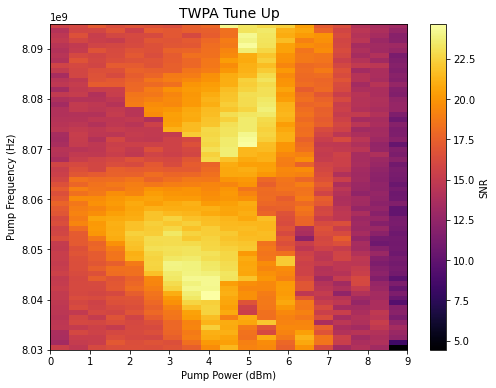

In [2]:
labber_data_file = str(input("Labber File Location: "))
repeated = int(input("Number of Repeations: "))
power_range = int(input("Number of Points for Power: "))
freq_range = int(input("Number of Points for Frequency: "))

std_highSNR = 1.15 # cut off point for determining high SNR
cutOff_around_SA_peak = 10e3 # Hz

lf = Labber.LogFile(labber_data_file)

power_channel_name = "10002F25 - Power"
freq_channel_name = "10002F25 - Frequency"
SA_channel_name = 'HP Spectrum Analyzer - Signal'

pump_power = lf.getData(name = power_channel_name)
pump_freq = lf.getData(name = freq_channel_name)

signal = lf.getData(name = SA_channel_name)
linsig = dBm2Watt(signal)

SAxdata, SAydata = lf.getTraceXY(y_channel=SA_channel_name) # gives last trace from SA

plt.rcParams['savefig.facecolor']='white'

get_SNR_space_plot(signal,repeated, freq_range, power_range, pump_freq,
                   pump_power, SAxdata, cutOff=cutOff_around_SA_peak,
                   title="TWPA Tune Up", xlabel='Pump Power (dBm)', 
                   ylabel='Pump Frequency (Hz)', zlabel='SNR', 
                   fig_type=".png", path="figures")




In [119]:
def get_high_SNR_regions(signal,repeated, freq_range, power_range,pump_freq, pump_power, SAxdata, cutOff=10e3, std_highSNR=1.75):
    average_signal = get_average_of_N_traces(signal,repeated)
    average_lin_signal = dBm2Watt(average_signal)

    pump_freqs = np.linspace(pump_freq[0][0],pump_freq[-1][-1],freq_range)
    pump_powers = np.linspace(pump_power[0][0],pump_power[-1][-1],power_range)

    SNRs, max_signals, noise_floors = calculate_SNRs(average_lin_signal,SAxdata,cutOff)
    SNRs_reshaped = np.reshape(SNRs, (freq_range,power_range))

    meanSNR = np.mean(SNRs_reshaped)
    region = get_config_for_high_SNR(SNRs_reshaped,x=pump_powers, y=pump_freqs,std_dev=std_highSNR)
    std_message = f"Region of High SNR\n[i.e SNR > mean(SNR) * std_dev(SNR)]\nmean(SNR) = {meanSNR:.3f}, std_dev(SNR) = {std_highSNR:.2f}"
    create_heatmap(region, pump_powers, pump_freqs, title = std_message, xlabel='Pump Power (dBm)', ylabel='Pump Frequency (Hz)', zlabel='SNR',)
    print_coordinates(get_coordinates(pump_powers, pump_freqs,region))
    return get_coordinates(pump_powers, pump_freqs,region)

def get_config_for_high_SNR(arr,x,y,std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    min_deviations = std_dev
    high_values = mean + min_deviations * standard_deviation

    arr[arr < high_values] = np.nan
    return arr


def get_coordinates(x,y,z):
    mask = np.isfinite(z)
    xx,yy = np.array(np.meshgrid(x, y))
    masked_x = mask*xx
    masked_y = mask*yy
    x = masked_x[masked_x>0]
    y = masked_y[masked_y>0]
    z = z[np.isfinite(z)]
    return np.array((x,y,z)).T

def print_coordinates(arr):
    for i in range(arr.shape[0]):
        print(f"SNR = {arr[i][2]:.3f} for Power = {arr[i][1]}and Frequency = {arr[i][0]}")

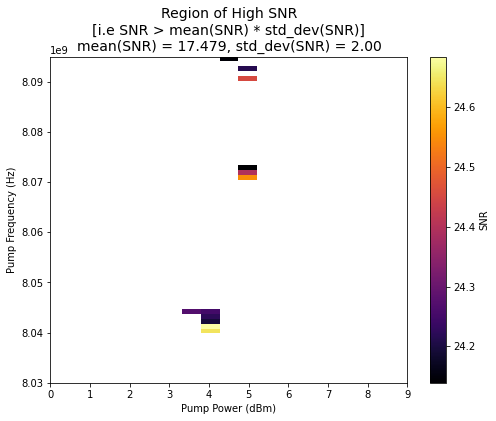

SNR = 24.645 for Power = 8040000000.0and Frequency = 4.0
SNR = 24.685 for Power = 8041000000.0and Frequency = 4.0
SNR = 24.194 for Power = 8042000000.0and Frequency = 4.0
SNR = 24.222 for Power = 8043000000.0and Frequency = 4.0
SNR = 24.272 for Power = 8044000000.0and Frequency = 3.5
SNR = 24.251 for Power = 8044000000.0and Frequency = 4.0
SNR = 24.550 for Power = 8071000000.0and Frequency = 5.0
SNR = 24.395 for Power = 8072000000.0and Frequency = 5.0
SNR = 24.139 for Power = 8073000000.0and Frequency = 5.0
SNR = 24.453 for Power = 8091000000.0and Frequency = 5.0
SNR = 24.215 for Power = 8093000000.0and Frequency = 5.0
SNR = 24.144 for Power = 8095000000.0and Frequency = 4.5


In [120]:
region= get_high_SNR_regions(signal,repeated, freq_range, power_range, pump_freq,
                         pump_power, SAxdata, cutOff=cutOff_around_SA_peak,
                         std_highSNR=2)

In [112]:
region.shape[0]

12

## SNR Methods

In [ ]:
import Labber
import os
import sys
from fitTools.utilities import Watt2dBm, dBm2Watt, VNA2dBm

from twpa_tune_up_helper_functions import *


In [ ]:
def calculate_mean_SNR_from_Labber_file(labber_data_file5, cutOff = 10e3):
    """
    """
    lf = Labber.LogFile(labber_data_file)
    SA_channel_name = 'HP Spectrum Analyzer - Signal'


    signal = lf.getData(name = SA_channel_name)
    linsig = dBm2Watt(signal)

    SAxdata, SAydata = lf.getTraceXY(y_channel=SA_channel_name, entry=0) # gives last trace from SA
    
    snrs = 0
    for i in range(len(signal)):
        snrs += get_signal_stats(dBm2Watt(signal[i]), SAxdata, cutOff)[0]

    snr_mean = snrs / len(signal)
    return snr_mean

**Testing SNR Code:**

In [ ]:
calculate_mean_SNR_from_Labber_file